# Title: Fashion Dataset evaluation with different CNN's

## CSCI 4050U Group Project

## Name:
* Bilal Nazar ---- 100830517
* Nicholas Lee ---- 100708259
* Jacob Rempel ---- 100823181
* Arujan Srimohan ---- 100750053
* Syeda Muqadas ----100825225


# Colab Link:
https://colab.research.google.com/drive/1RxhVVBup-LHtoh88s4hptn1xdMu3NeTv?usp=sharing

# Problem Statement


### Effectively categorizing fashion products is critical for providing improved user experiences, such as smart searches, personalized recommendations, and inventory management. While simple classifiers may be effective for fundamental tasks, they frequently fail when confronted with high-dimensional data and intricate patterns present in fashion images of products. Our goal is to understand the intricacies in classifying photos of fashion products into categories and understanding what makes it so hard to map out specific features to categorize T-shirts, shoes, bags etc.

In [ ]:
! pip install portalocker==2.8.2 lightning torchinfo keras_preprocessing --quiet
! pip install tqdm

import pandas as pd
import warnings
import shutil
import torch
import torchvision
import torchmetrics
import matplotlib.pyplot as plt

import kagglehub

from torch import nn
from torch import Tensor
from torch.utils.data import random_split, DataLoader
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything, LightningModule
from typing import Tuple
from importlib import reload

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

# add images column to the df
df = pd.read_csv(path + "/styles.csv", on_bad_lines='skip') # entire dataset

print("Path to dataset files:", path)

100%|██████████| 565M/565M [00:07<00:00, 83.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1


In [ ]:
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
# display categories
print(sorted(df['articleType'].unique()))

['Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle', 'Basketballs', 'Bath Robe', 'Beauty Accessory', 'Belts', 'Blazers', 'Body Lotion', 'Body Wash and Scrub', 'Booties', 'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Camisoles', 'Capris', 'Caps', 'Casual Shoes', 'Churidar', 'Clothing Set', 'Clutches', 'Compact', 'Concealer', 'Cufflinks', 'Cushion Covers', 'Deodorant', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings', 'Eye Cream', 'Eyeshadow', 'Face Moisturisers', 'Face Scrub and Exfoliator', 'Face Serum and Gel', 'Face Wash and Cleanser', 'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Foundation and Primer', 'Fragrance Gift Set', 'Free Gifts', 'Gloves', 'Hair Accessory', 'Hair Colour', 'Handbags', 'Hat', 'Headband', 'Heels', 'Highlighter and Blush', 'Innerwear Vests', 'Ipad', 'Jackets', 'Jeans', 'Jeggings', 'Jewellery Set', 'Jumpsuit', 'Kajal and Eyeliner', 'Key chain', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag', 'Leggings', 'Lehenga Choli', 'Lip Care', 'Lip Gloss', 'Lip Liner'

# Build model class (Based on Assignment 2)

In [ ]:
class BasicConvModel(LightningModule):
  def __init__(self, num_labels, image_size_x=60, image_size_y=80):
    super().__init__()
    self.num_labels = num_labels
    self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=num_labels)

    self.linear_layer_size = 256 * (image_size_x // 4) * (image_size_y // 4)

    self.model = nn.Sequential(
          # First layer
          nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),  # 3 channel -> 16 channels
          nn.MaxPool2d(kernel_size=2), #image size: 60x80 -> 30x40
          nn.ReLU(),

          # Second conv layer
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 16 channels -> 32 channels
          nn.MaxPool2d(kernel_size=2), #image size: 30x40 -> 15x20
          nn.ReLU(),

          # Flatten layer
          nn.Flatten(),  # 256*15*20 -> 76 800

          # Linear layer
          nn.Linear(self.linear_layer_size, self.num_labels)
      )

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters())

  def shared_step(self, mode:str, batch:Tuple[Tensor, Tensor], batch_index:int):
      x, target = batch
      output = self.forward(x)
      loss = self.loss(output, target)
      self.accuracy(output, target)
      self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
      self.log(f"{mode}_step_loss", loss, prog_bar=False)
      return loss

  def training_step(self, batch, batch_index):
      return self.shared_step('train', batch, batch_index)

  def validation_step(self, batch, batch_index):
      return self.shared_step('val', batch, batch_index)

  def test_step(self, batch, batch_index):
      return self.shared_step('test', batch, batch_index)

  def forward(self, x):
      return self.model(x)

  def loss(self, logits, target):
        return nn.functional.cross_entropy(logits, target)

In [ ]:
# describe model
import torchinfo

batch_size = 32

def describe(model, image_size_x=60, image_size_y=80, **kwargs):
    return torchinfo.summary(model,
                             input_size=(batch_size, 3, image_size_x, image_size_y),
                             col_names=['input_size', 'output_size', 'kernel_size', 'num_params'],
                             row_settings=['ascii_only'])

In [ ]:
# function to display accuracy
def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_step_acc']].dropna().plot()
    df[['val_step_acc']].dropna().plot(ax=ax);
    return df[['val_step_acc']].dropna().round(2)

In [ ]:
model = BasicConvModel(70)
describe(model)
# model = BasicConvModel(146, 64, 64)
# describe(model, 64, 64)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
BasicConvModel                           [32, 3, 60, 80]           [32, 70]                  --                        --
+ Sequential                             [32, 3, 60, 80]           [32, 70]                  --                        --
|    + Conv2d                            [32, 3, 60, 80]           [32, 128, 60, 80]         [3, 3]                    3,584
|    + MaxPool2d                         [32, 128, 60, 80]         [32, 128, 30, 40]         2                         --
|    + ReLU                              [32, 128, 30, 40]         [32, 128, 30, 40]         --                        --
|    + Conv2d                            [32, 128, 30, 40]         [32, 256, 30, 40]         [3, 3]                    295,168
|    + MaxPool2d                         [32, 256, 30, 40]         [32, 256, 15, 20]         2                         --
|    + ReLU

In [ ]:
# functions to load dataset into dataloaders and train the model from those dataloaders
import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything
from keras_preprocessing.image import ImageDataGenerator

batch_size = 32

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os

# this class allows the dataframe to be loaded and read as [x, targets]
class CustomDataset(Dataset):
    def __init__(self, image_size_x=60, image_size_y=80):

      df = pd.read_csv(path + "/styles.csv", on_bad_lines='skip') # entire dataset
      series = df['articleType'].value_counts()
      filtered = series[series >= 50].index
      self.annotations = df[df['articleType'].isin(filtered)]

      self.removeIds = [12347, 39410, 39401, 39403, 39425]
      for i in self.removeIds:
        self.annotations.drop(self.annotations[self.annotations['id'] == i].index, inplace = True) # removes an entry where no jpg exists

      self.image_size_x = image_size_x
      self.image_size_y = image_size_y


      self.lookupCategory = {
        'Accessory Gift Set': 0,
        'Backpacks': 1,
        'Bangle': 2,
        'Belts': 3,
        'Boxers': 4,
        'Bra': 5,
        'Bracelet': 6,
        'Briefs': 7,
        'Capris': 8,
        'Caps': 9,
        'Casual Shoes': 10,
        'Clutches': 11,
        'Cufflinks': 12,
        'Deodorant': 13,
        'Dresses': 14,
        'Duffel Bag': 15,
        'Dupatta': 16,
        'Earrings': 17,
        'Face Moisturisers': 18,
        'Flats': 19,
        'Flip Flops': 20,
        'Formal Shoes': 21,
        'Foundation and Primer': 22,
        'Fragrance Gift Set': 23,
        'Free Gifts': 24,
        'Handbags': 25,
        'Heels': 26,
        'Highlighter and Blush': 27,
        'Innerwear Vests': 28,
        'Jackets': 29,
        'Jeans': 30,
        'Jewellery Set': 31,
        'Kajal and Eyeliner': 32,
        'Kurta Sets': 33,
        'Kurtas': 34,
        'Kurtis': 35,
        'Laptop Bag': 36,
        'Leggings': 37,
        'Lip Gloss': 38,
        'Lipstick': 39,
        'Lounge Pants': 40,
        'Nail Polish': 41,
        'Necklace and Chains': 42,
        'Night suits': 43,
        'Nightdress': 44,
        'Pendant': 45,
        'Perfume and Body Mist': 46,
        'Ring': 47,
        'Sandals': 48,
        'Sarees': 49,
        'Scarves': 50,
        'Shirts': 51,
        'Shorts': 52,
        'Skirts': 53,
        'Socks': 54,
        'Sports Sandals': 55,
        'Sports Shoes': 56,
        'Stoles': 57,
        'Sunglasses': 58,
        'Sweaters': 59,
        'Sweatshirts': 60,
        'Ties': 61,
        'Tops': 62,
        'Track Pants': 63,
        'Trousers': 64,
        'Trunk': 65,
        'Tshirts': 66,
        'Tunics': 67,
        'Wallets': 68,
        'Watches': 69
      }

    def __len__(self):
      return len(self.annotations)

    def __getitem__(self, index):
      img_path = os.path.join(path + "/images", str(self.annotations.iloc[index, 0]) + ".jpg")
      image = Image.open(img_path)

      y_label = torch.tensor(self.lookupCategory[self.annotations.iloc[index, 4]]) #fetches a label from column 4: articleType

      # define transform
      transform = transforms.Compose([
          transforms.Resize((self.image_size_x, self.image_size_y)),
          transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
          transforms.ToTensor(),  # Convert image to tensor (scaled to [0, 1])
      ])

      image = transform(image)
      return (image, y_label)

In [ ]:
dataset = CustomDataset()
# dataset = CustomDataset(64, 64) # for 64x64 images

<ipython-input-11-974fb66ff654>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.annotations.drop(self.annotations[self.annotations['id'] == i].index, inplace = True) # removes an entry where no jpg exists


In [ ]:
train, valid = random_split(dataset, (0.8, 0.2))

train_loader = DataLoader(train, batch_size=batch_size)
valid_loader = DataLoader(valid, batch_size=batch_size)

In [ ]:
def train(model):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=name)
    trainer = Trainer(max_epochs=20, logger=logger, deterministic=True)
    trainer.fit(model,
                train_dataloaders=train_loader,
                val_dataloaders=valid_loader)

In [ ]:
train(model)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | Sequential         | 5.7 M  | train
--------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.699    Total estimated model params size (MB)
10        Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


,val_step_acc
step,
1083,0.70
2167,0.81
3251,0.85
4335,0.87
5419,0.89
6503,0.91
7587,0.92
8671,0.92
9755,0.92


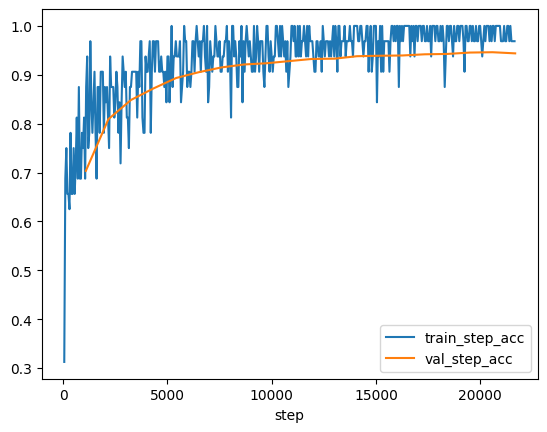

In [ ]:
show_metrics('BasicConvModel')

# Replicating a Tiny VGG architecture for the 2nd model

In [ ]:
class ModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set ourselves in our NN' are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 300, # Fix this
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x


In [ ]:
series = df['articleType'].value_counts()
filtered = series[series >= 50].index
df = df[df['articleType'].isin(filtered)]
df['articleType'].value_counts()
class_names = sorted(df['articleType'].unique())

print(len(class_names))
print(class_names)

70
['Accessory Gift Set', 'Backpacks', 'Bangle', 'Belts', 'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Capris', 'Caps', 'Casual Shoes', 'Clutches', 'Cufflinks', 'Deodorant', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings', 'Face Moisturisers', 'Flats', 'Flip Flops', 'Formal Shoes', 'Foundation and Primer', 'Fragrance Gift Set', 'Free Gifts', 'Handbags', 'Heels', 'Highlighter and Blush', 'Innerwear Vests', 'Jackets', 'Jeans', 'Jewellery Set', 'Kajal and Eyeliner', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag', 'Leggings', 'Lip Gloss', 'Lipstick', 'Lounge Pants', 'Nail Polish', 'Necklace and Chains', 'Night suits', 'Nightdress', 'Pendant', 'Perfume and Body Mist', 'Ring', 'Sandals', 'Sarees', 'Scarves', 'Shirts', 'Shorts', 'Skirts', 'Socks', 'Sports Sandals', 'Sports Shoes', 'Stoles', 'Sunglasses', 'Sweaters', 'Sweatshirts', 'Ties', 'Tops', 'Track Pants', 'Trousers', 'Trunk', 'Tshirts', 'Tunics', 'Wallets', 'Watches']


In [ ]:
torch.manual_seed(42)
model_2 = ModelV2(input_shape=3,
                  hidden_units=35, # NOTE: When i ran locally i used 30 instead of 10, i put 10 here cuz 30 might take too long
                  output_shape=len(class_names)).to(device)

In [ ]:
# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Train step function

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss = 0
  train_acc = 0

  # Model is in training mode
  model.train()

  # Loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    # Place the data on the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward()
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc


In [ ]:
# Test step function

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss = 0
  test_acc = 0

  # Put model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")
    return test_loss, test_acc



In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = {
  "train_loss": [],
  "train_acc": [],
  "test_loss": [],
  "test_acc": []
}

# Measure the time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in range(epochs):
  print(f"Epoch: {epoch}")
  train_loss, train_acc = train_step(model=model_2,
             data_loader=train_loader,
            #  data_loader=DataLoader(dataset),
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_loss, test_acc = test_step(model=model_2,
            data_loader=valid_loader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  # Update results dictionary
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)

train_time_end_model_2 = timer()
total_train_time_model_2 = train_time_end_model_2 - train_time_start_model_2

print(total_train_time_model_2)


Epoch: 0
Train loss: 2.51380 | Train acc: 35.71%
Test loss: 2.50764 | Test acc: 43.43%

Epoch: 1
Train loss: 1.26268 | Train acc: 63.58%
Test loss: 1.50879 | Test acc: 59.94%

Epoch: 2
Train loss: 0.92857 | Train acc: 72.36%
Test loss: 1.27986 | Test acc: 65.70%

Epoch: 3
Train loss: 0.78215 | Train acc: 76.21%
Test loss: 1.21394 | Test acc: 67.66%

Epoch: 4
Train loss: 0.68496 | Train acc: 78.95%
Test loss: 1.12244 | Test acc: 69.61%

Epoch: 5
Train loss: 0.60615 | Train acc: 81.32%
Test loss: 0.93915 | Test acc: 73.04%

Epoch: 6
Train loss: 0.53968 | Train acc: 83.19%
Test loss: 0.79115 | Test acc: 76.50%

Epoch: 7
Train loss: 0.48181 | Train acc: 84.86%
Test loss: 0.75330 | Test acc: 77.76%

Epoch: 8
Train loss: 0.43048 | Train acc: 86.38%
Test loss: 0.70610 | Test acc: 79.40%

Epoch: 9
Train loss: 0.38415 | Train acc: 87.83%
Test loss: 0.72564 | Test acc: 79.29%

520.4557277270001


In [ ]:
# Make the graph
def plot_loss_curves(results):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)

  loss = []
  test_loss = []

  for result in results["test_loss"]:
      loss.append(result.item())

  for result in results["train_loss"]:
      test_loss.append(result.item())


  # Get the accuracy values of the results dictionary (training and test)
  accruacy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accruacy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

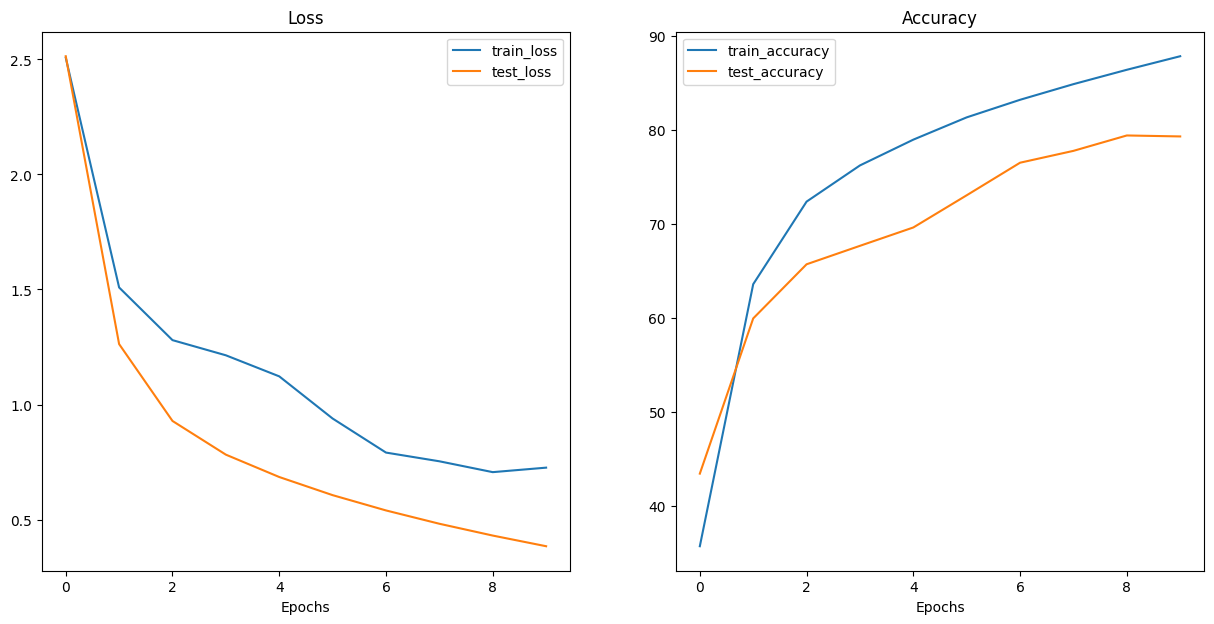

In [ ]:
plot_loss_curves(results)

In [ ]:
lookupCategory = {
  'Accessory Gift Set': 0,
  'Backpacks': 1,
  'Bangle': 2,
  'Belts': 3,
  'Boxers': 4,
  'Bra': 5,
  'Bracelet': 6,
  'Briefs': 7,
  'Capris': 8,
  'Caps': 9,
  'Casual Shoes': 10,
  'Clutches': 11,
  'Cufflinks': 12,
  'Deodorant': 13,
  'Dresses': 14,
  'Duffel Bag': 15,
  'Dupatta': 16,
  'Earrings': 17,
  'Face Moisturisers': 18,
  'Flats': 19,
  'Flip Flops': 20,
  'Formal Shoes': 21,
  'Foundation and Primer': 22,
  'Fragrance Gift Set': 23,
  'Free Gifts': 24,
  'Handbags': 25,
  'Heels': 26,
  'Highlighter and Blush': 27,
  'Innerwear Vests': 28,
  'Jackets': 29,
  'Jeans': 30,
  'Jewellery Set': 31,
  'Kajal and Eyeliner': 32,
  'Kurta Sets': 33,
  'Kurtas': 34,
  'Kurtis': 35,
  'Laptop Bag': 36,
  'Leggings': 37,
  'Lip Gloss': 38,
  'Lipstick': 39,
  'Lounge Pants': 40,
  'Nail Polish': 41,
  'Necklace and Chains': 42,
  'Night suits': 43,
  'Nightdress': 44,
  'Pendant': 45,
  'Perfume and Body Mist': 46,
  'Ring': 47,
  'Sandals': 48,
  'Sarees': 49,
  'Scarves': 50,
  'Shirts': 51,
  'Shorts': 52,
  'Skirts': 53,
  'Socks': 54,
  'Sports Sandals': 55,
  'Sports Shoes': 56,
  'Stoles': 57,
  'Sunglasses': 58,
  'Sweaters': 59,
  'Sweatshirts': 60,
  'Ties': 61,
  'Tops': 62,
  'Track Pants': 63,
  'Trousers': 64,
  'Trunk': 65,
  'Tshirts': 66,
  'Tunics': 67,
  'Wallets': 68,
  'Watches': 69
}

inv_map = {v: k for k, v in lookupCategory.items()}



# Code for light deployment of model

Saving A92FD022-5443-421D-B4FB-881DC9AB8AB7.webp to A92FD022-5443-421D-B4FB-881DC9AB8AB7.webp


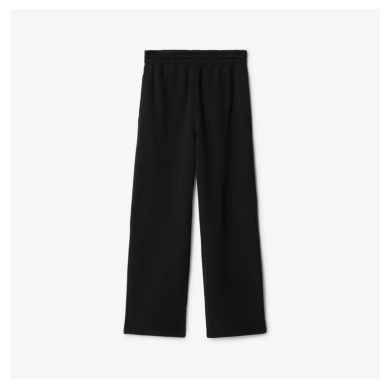

Predicted Class: Track Pants


In [ ]:
import torch
import torchvision.transforms
from PIL import Image
from google.colab import files

# Set model to evaulation mode to use running statistics on all training data
# For normalization layers and deactivate dropout layers
model.eval()

transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  # Convert image to tensor (scaled to [0, 1])
])

def predict(image_path):
  image = Image.open(image_path)
  input_tensor = transform(image)
  #Add dimension for batch size at index 0 with unsqueeze function
  input_tensor = input_tensor.unsqueeze(0)

  #turn off gradient computations and perform inference
  with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
  return predicted_class

uploaded_image = files.upload()
image_path = list(uploaded_image.keys())[0]

image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.show()

predicted_class = predict(image_path)


print(f"Predicted Class: {inv_map[predicted_class]}")

# Code for light deployment of model_2

Saving A92FD022-5443-421D-B4FB-881DC9AB8AB7.webp to A92FD022-5443-421D-B4FB-881DC9AB8AB7 (1).webp


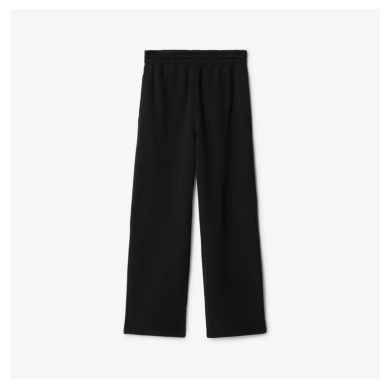

Predicted Class: Track Pants


In [ ]:
import torch
import torchvision.transforms
from PIL import Image
from google.colab import files

model_2.eval()

transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  # Convert image to tensor (scaled to [0, 1])
])

def predict(image_path):
  image = Image.open(image_path)
  input_tensor = transform(image)
  #Add dimension for batch size at index 0 with unsqueeze function
  input_tensor = input_tensor.unsqueeze(0).to(device)

  #turn off gradient computations and perform inference
  with torch.no_grad():
    output = model_2(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
  return predicted_class

uploaded_image = files.upload()
image_path = list(uploaded_image.keys())[0]

image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.show()

predicted_class = predict(image_path)


print(f"Predicted Class: {inv_map[predicted_class]}")